In [4]:
import numpy as np
import pandas as pd

In [5]:
DATASET_PATH = './train.csv'
PREPARED_DATASET_PATH = './train_prepared.csv'

In [6]:
df = pd.read_csv(DATASET_PATH, sep=',')

# Уменьшение объема памяти датасета

In [7]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col]. astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
                       
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                       df[col] = df[col].astype(np.float32)
                else:
                       df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:1f}%'.format(100 * (start_mem - end_mem) / start_mem))
                       
    return df

# Визуализация данных

In [8]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [9]:
matplotlib.rcParams.update({'font.size': 14}) # размер шрифта на всех графиках

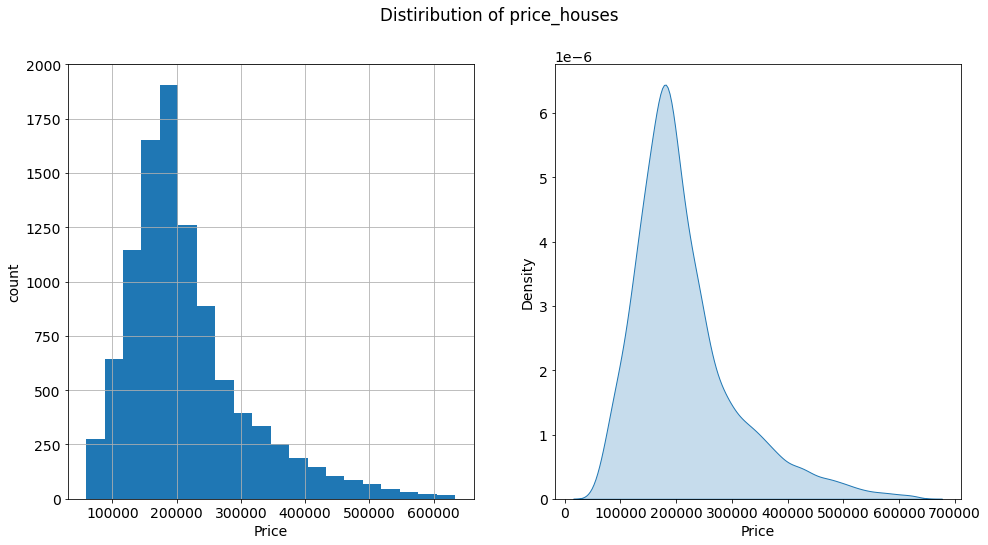

In [10]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
df['Price'].hist(density=False, bins=20)
plt.xlabel('Price')
plt.ylabel('count')

plt.subplot(122)
sns.kdeplot(df['Price'], shade=True, legend=False)
plt.xlabel('Price')

plt.suptitle('Distiribution of price_houses')
plt.show()

In [11]:
target_mean = round(df['Price'].mean(), 2)
target_median = df['Price'].median()
target_mode = round(df['Price'].mode()[0], 2)
target_mean, target_median, target_mode

(214138.86, 192269.64487934904, 59174.78)

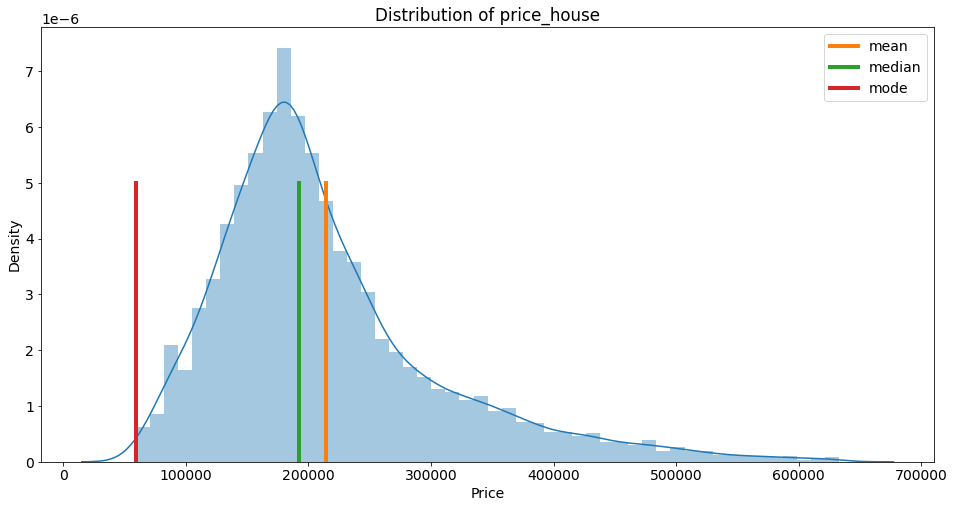

In [12]:
plt.figure(figsize = (16, 8))

sns.distplot(df['Price'], bins=50)

y = np.linspace(0, 0.000005, 10)
plt.plot([target_mean] * 10, y, label='mean', linewidth=4)
plt.plot([target_median] * 10, y, label='median', linewidth=4)
plt.plot([target_mode] * 10, y, label='mode', linewidth=4)

plt.title('Distribution of price_house')
plt.legend()
plt.show()

### Анализ признаков

In [13]:
df_num_features = df.select_dtypes(include=['float64', 'float32', 'float16'])
df_num_features.drop('Price', axis=1, inplace=True)

In [14]:
df_num_features.head()

,Rooms,Square,LifeSquare,KitchenSquare,HouseFloor,Ecology_1,Healthcare_1
0,3.0,115.027311,NaN,10.0,10.0,0.075424,NaN
1,1.0,39.832524,23.169223,8.0,8.0,0.118537,1183.0
2,3.0,78.342215,47.671972,10.0,17.0,0.025609,240.0
3,1.0,40.409907,NaN,1.0,22.0,0.007122,NaN
4,2.0,64.285067,38.562517,9.0,16.0,0.282798,NaN


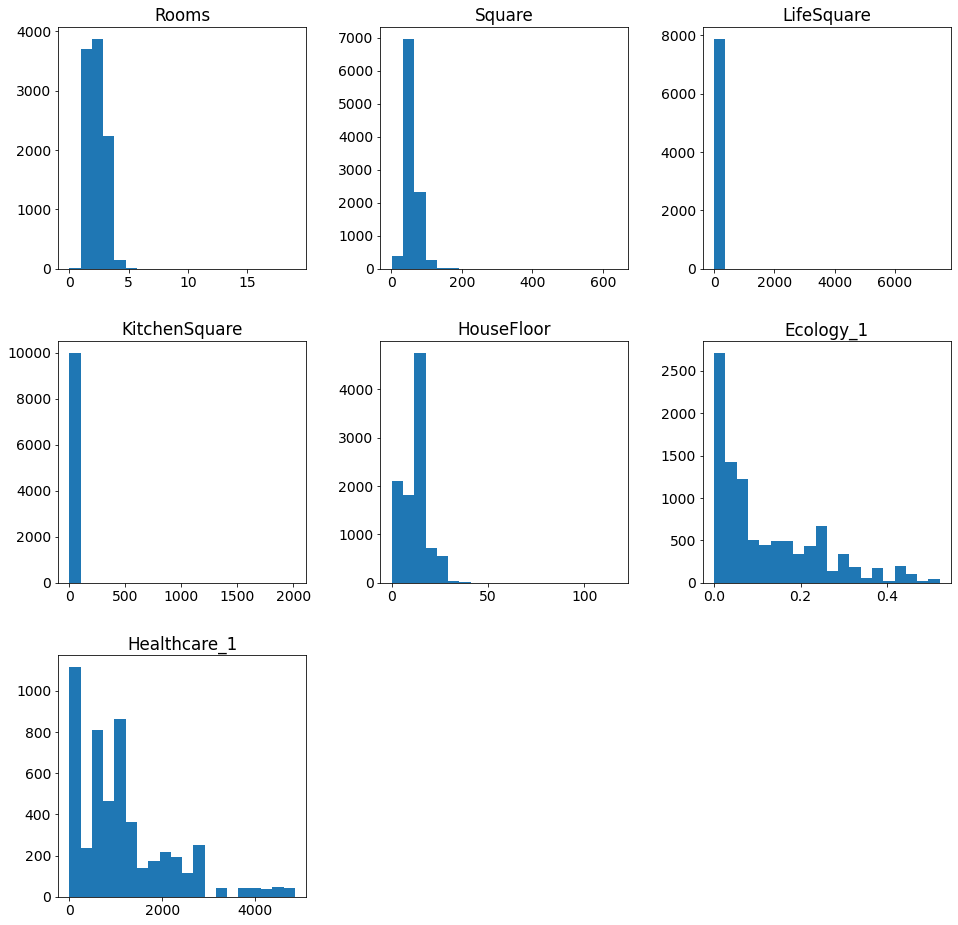

In [15]:
df_num_features.hist(figsize=(16, 16), bins=20, grid=False)
plt.show()

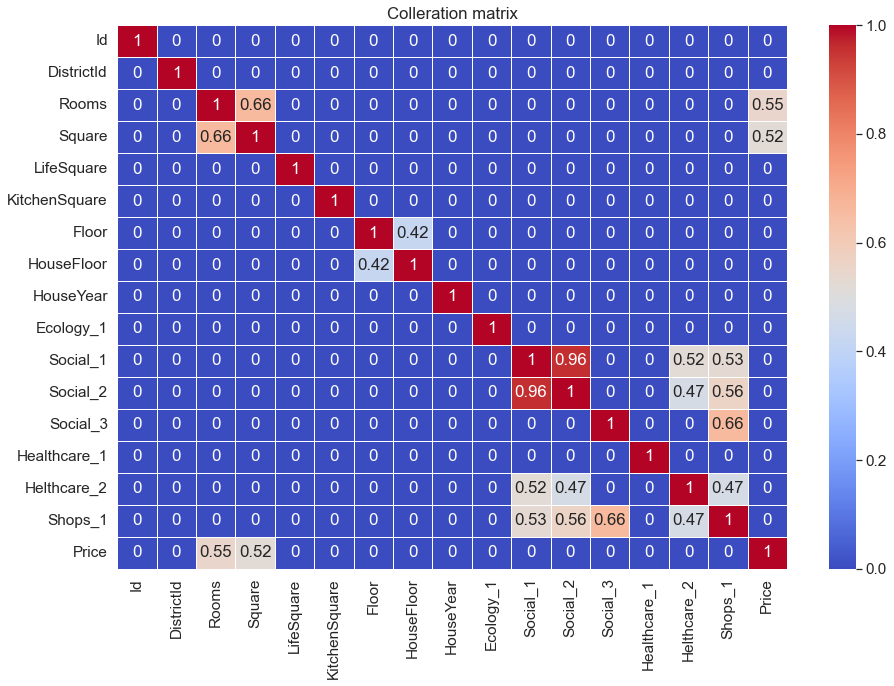

In [16]:
plt.figure(figsize=(15, 10))

sns.set(font_scale=1.4)

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.4] = 0

sns.heatmap(corr_matrix, annot=True, linewidth=.5, cmap='coolwarm')

plt.title('Colleration matrix')
plt.show()

### Обработка NaN

In [17]:
df['LifeSquare_nan'] = 0
df.loc[df['LifeSquare'].isna(), 'LifeSquare_nan'] = 1

In [18]:
df['Healthcare_1_nan'] = 0
df.loc[df['Healthcare_1'].isna(), 'Healthcare_1_nan'] = 1

In [19]:
medians = df[['LifeSquare', 'Healthcare_1']].median()
medians

LifeSquare       32.78126
Healthcare_1    900.00000
dtype: float64

In [20]:
df[['LifeSquare', 'Healthcare_1']] = df[['LifeSquare', 'Healthcare_1']].fillna(medians)

### Обработка выбросов

#### Количество комнат

In [21]:
rooms_max_value = np.quantile(df['Rooms'], q=0.99)
rooms_max_value

4.0

In [22]:
rooms_min_value = np.quantile(df['Rooms'], q=0.025)
rooms_min_value

1.0

In [23]:
condition = (df['Rooms'] > rooms_max_value) | (df['Rooms'] < rooms_min_value)
df['Rooms_outlier'] = 0
df.loc[condition, 'Rooms_outlier'] = 1
df.loc[condition, ['Rooms']] = df['Rooms'].median()
df['Rooms'].describe()

count    10000.000000
mean         1.883000
std          0.800234
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          4.000000
Name: Rooms, dtype: float64

#### Площадь квартиры

In [24]:
square_max_value = np.quantile(df['Square'], q=0.975)
square_max_value

100.90624548226137

In [25]:
square_min_value = np.quantile(df['Square'], q=0.025)
square_min_value

32.10518291149681

In [26]:
condition = (df['Square'] > square_max_value) | (df['Square'] < square_min_value)
df[condition]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan,Healthcare_1_nan,Rooms_outlier
0,11809,27,3.0,115.027311,32.781260,10.0,4,10.0,2014,0.075424,...,3097,0,900.0,0,0,B,305018.871089,1,1,0
32,3876,100,4.0,104.769022,79.316650,8.0,4,8.0,1960,0.200147,...,3975,8,770.0,2,0,B,600903.828562,0,0,0
63,11630,58,1.0,30.961868,15.168644,6.0,3,12.0,1973,0.310199,...,2748,1,900.0,0,0,B,117941.286753,0,1,0
92,2357,32,1.0,31.828480,15.222565,5.0,5,5.0,1972,0.135650,...,7960,6,350.0,3,11,B,170343.755036,0,0,0
108,8871,91,1.0,31.691657,20.108517,5.0,1,5.0,1965,0.000995,...,7651,1,900.0,1,5,B,140029.719549,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9915,8998,20,1.0,30.082090,12.125029,7.0,9,9.0,1976,0.019509,...,7687,11,176.0,5,5,B,186537.391208,0,0,0
9937,6149,53,4.0,109.905861,94.268671,20.0,12,24.0,2018,0.049637,...,7759,0,229.0,1,3,B,492943.252891,0,0,0
9971,7800,46,3.0,105.649530,63.452792,12.0,13,22.0,2014,0.188784,...,6137,4,900.0,0,1,B,500562.663412,0,1,0
9990,10635,21,1.0,18.983962,11.419796,2.0,1,5.0,1967,0.194489,...,8004,3,125.0,3,5,B,112411.221700,0,0,0


In [27]:
df['Square_outlier'] = 0
df.loc[condition, 'Square_outlier'] = 1

In [28]:
df.loc[condition, 'Square'] = df['Square'].median()
df['Square'].describe()

count    10000.000000
mean        55.108599
std         15.215053
min         32.105270
25%         42.432730
50%         52.513310
75%         64.591720
max        100.904263
Name: Square, dtype: float64

#### Жилая площадь

In [29]:
df['LifeSquare'].describe()

count    10000.000000
mean        36.266040
std         76.609981
min          0.370619
25%         25.527399
50%         32.781260
75%         41.427234
max       7480.592129
Name: LifeSquare, dtype: float64

In [30]:
lifesquare_max_value = np.quantile(df['LifeSquare'], q=0.975)
lifesquare_max_value

78.3859441855343

In [31]:
lifesquare_min_value = np.quantile(df['LifeSquare'], q=0.025)
lifesquare_min_value

15.146123972262354

In [32]:
condition = (df['LifeSquare'] < lifesquare_min_value) | (df['LifeSquare'] > lifesquare_max_value)
df[condition]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan,Healthcare_1_nan,Rooms_outlier,Square_outlier
26,8553,88,3.0,83.262530,4.769174,1.0,13,1.0,1977,0.127376,...,3,900.0,3,9,B,410883.892020,0,1,0,0
32,3876,100,4.0,52.513310,79.316650,8.0,4,8.0,1960,0.200147,...,8,770.0,2,0,B,600903.828562,0,0,0,1
64,3992,1,3.0,87.200625,87.730225,0.0,21,22.0,1977,0.007122,...,0,900.0,0,1,B,300180.365669,0,1,0,0
100,13343,74,2.0,79.937665,82.931595,1.0,8,21.0,1977,0.075779,...,3,900.0,0,2,B,226808.747168,0,1,0,0
119,5112,6,2.0,63.591740,0.795539,10.0,17,17.0,2014,0.243205,...,0,540.0,0,0,B,174741.998061,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9960,16258,48,3.0,96.056784,98.152802,1.0,15,1.0,2017,0.041125,...,5,900.0,1,10,B,524365.550705,0,1,0,0
9965,6441,52,3.0,85.796885,85.305246,0.0,15,17.0,1977,0.371149,...,1,750.0,2,5,B,204462.983720,0,0,0,0
9982,10268,27,1.0,36.112393,1.855415,1.0,9,16.0,1977,0.211401,...,0,900.0,0,1,B,94881.691800,0,1,0,0
9990,10635,21,1.0,52.513310,11.419796,2.0,1,5.0,1967,0.194489,...,3,125.0,3,5,B,112411.221700,0,0,0,1


In [33]:
df['LifeSquare_outlier'] = 0
df.loc[condition, 'LifeSquare_outlier'] = 1

In [34]:
df.loc[condition, 'LifeSquare'] = (df['LifeSquare'] / df['Square']).median() * df['Square']
round(df['LifeSquare'], 0).describe()

count    10000.000000
mean        34.932800
std         11.767937
min         15.000000
25%         28.000000
50%         33.000000
75%         41.000000
max         78.000000
Name: LifeSquare, dtype: float64

#### Кухни

In [35]:
kitchen_max_value = np.quantile(df['KitchenSquare'], q=0.99)
kitchen_max_value

16.0

In [36]:
df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
30.0         2
43.0         2
41.0         2
112.0        2
25.0         2
51.0         2
37.0         2
58.0         2
32.0         2
21.0         1
73.0         1
75.0         1
36.0         1
27.0         1
63.0         1
1970.0       1
54.0         1
53.0         1
60.0         1
26.0         1
66.0         1
39.0         1
29.0         1
78.0         1
31.0         1
84.0         1
48.0         1
96.0         1
42.0         1
40.0         1
23.0         1
72.0         1
35.0         1
62.0         1
123.0        1
2014.0       1
Name: KitchenSquare, dtype: int64

In [37]:
kitchen_min_value = np.quantile(df['KitchenSquare'], q=0.025)
kitchen_min_value

0.0

In [38]:
condition = (df['KitchenSquare'] < kitchen_min_value) | (df['KitchenSquare'] > kitchen_max_value)
df[condition]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan,Healthcare_1_nan,Rooms_outlier,Square_outlier,LifeSquare_outlier
277,13559,79,1.0,96.838013,49.140960,22.0,19,24.0,2016,0.050756,...,145.0,0,1,B,348962.861294,0,0,0,0,0
286,2737,27,3.0,52.513310,32.202550,123.0,5,10.0,2015,0.017647,...,900.0,0,0,B,234194.837047,0,1,0,1,1
456,10546,62,1.0,46.013187,43.417043,43.0,4,17.0,2019,0.072158,...,900.0,0,0,A,113909.099428,0,1,0,0,0
511,8685,62,2.0,52.513310,32.202550,30.0,5,3.0,2017,0.072158,...,900.0,0,0,A,271919.866048,0,1,1,1,1
682,16593,52,2.0,64.859242,32.781260,62.0,15,17.0,1977,0.371149,...,750.0,2,5,B,185993.474671,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9743,14754,23,3.0,52.513310,56.801439,20.0,2,2.0,2017,0.014073,...,900.0,0,0,B,231464.510346,0,1,0,1,0
9746,7857,27,2.0,43.956044,26.955008,19.0,15,17.0,2006,0.075424,...,900.0,0,0,B,143688.076514,0,1,0,0,1
9810,16408,9,1.0,40.226907,37.849083,19.0,8,17.0,1993,0.161532,...,30.0,2,4,B,137595.610782,0,0,0,0,0
9860,3431,62,2.0,60.715426,40.720961,25.0,5,12.0,2012,0.386772,...,900.0,0,0,A,172366.012197,0,1,0,0,0


In [39]:
df['KitchenSquare_outlier'] = 0
df.loc[condition, 'KitchenSquare_outlier'] = 1

In [40]:
df.loc[condition, 'KitchenSquare'] = df['KitchenSquare'].median()
df['KitchenSquare'].describe()

count    10000.000000
mean         5.621400
std          3.779245
min          0.000000
25%          1.000000
50%          6.000000
75%          9.000000
max         16.000000
Name: KitchenSquare, dtype: float64

###### Жилая площадь > площади за вычетом кухни

In [41]:
df['NonresidentialSquare'] = df['Square'] - df['LifeSquare'] - df['KitchenSquare']
df['NonresidentialSquare'].describe()

count    10000.000000
mean        14.600225
std         11.956952
min        -39.317983
25%          8.621456
50%         12.706299
75%         19.538822
max         66.637482
Name: NonresidentialSquare, dtype: float64

In [42]:
condition = (df['LifeSquare'] >= (df['Square'] - df['KitchenSquare']))

In [43]:
df.loc[condition, 'Square_outlier'] = 1

In [44]:
df.loc[condition, 'Square'] = df['LifeSquare'] + df['KitchenSquare'] + df['NonresidentialSquare'].median()

In [45]:
df['NonresidentialSquare'] = df['Square'] - df['LifeSquare'] - df['KitchenSquare']
df['NonresidentialSquare'].describe()

count    10000.000000
mean        16.086256
std         10.130851
min          0.021395
25%          9.863840
50%         12.706817
75%         19.538822
max         66.637482
Name: NonresidentialSquare, dtype: float64

#### Этажность Дома

In [46]:
df['HouseFloor'].describe()

count    10000.000000
mean        12.609400
std          6.775974
min          0.000000
25%          9.000000
50%         13.000000
75%         17.000000
max        117.000000
Name: HouseFloor, dtype: float64

In [47]:
housefloor_max_value = np.quantile(df['HouseFloor'], q=0.99)
housefloor_max_value

25.0

In [48]:
condition = (df['HouseFloor'] > housefloor_max_value) | (df['HouseFloor'] == 0)

In [49]:
df['HouseFloor_outlier'] = 0
df.loc[condition, 'HouseFloor_outlier'] = 1

In [50]:
df.loc[condition, 'HouseFloor'] = df['HouseFloor'].median()

#### Корректировка этажности дома относительно этажа квартиры

In [51]:
df['Floor_outlier'] = 0

In [52]:
df.loc[(df['HouseFloor'] < df['Floor']), 'Floor_outlier'] = 1

In [53]:
df['Floor_outlier'].value_counts()

0    8358
1    1642
Name: Floor_outlier, dtype: int64

In [54]:
df.loc[(df['HouseFloor'] < df['Floor']), 'Floor']  = df['HouseFloor']

### Возраст дома

In [55]:
df['HouseYear'].describe()

count    1.000000e+04
mean     3.990166e+03
std      2.005003e+05
min      1.910000e+03
25%      1.974000e+03
50%      1.977000e+03
75%      2.001000e+03
max      2.005201e+07
Name: HouseYear, dtype: float64

In [56]:
house_year_min_value = np.quantile(df['HouseYear'], q=0.025)
house_year_min_value

1959.0

In [57]:
condition = ((df['HouseYear'] < house_year_min_value) | (df['HouseYear'] > 2021))
df[condition]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Price,LifeSquare_nan,Healthcare_1_nan,Rooms_outlier,Square_outlier,LifeSquare_outlier,KitchenSquare_outlier,NonresidentialSquare,HouseFloor_outlier,Floor_outlier
39,3736,167,2.0,56.712771,36.454064,7.0,5.0,5.0,1956,0.050272,...,299177.502635,0,0,0,0,0,0,13.258708,0,1
50,9629,124,3.0,78.275227,58.330876,6.0,9.0,9.0,1953,0.169091,...,387904.136320,0,1,0,0,0,0,13.944351,0,0
51,12774,157,2.0,62.747509,28.196813,8.0,5.0,10.0,1956,0.000000,...,555661.943969,0,0,0,0,0,0,26.550696,0,0
106,12997,4,3.0,75.128389,52.754246,8.0,9.0,9.0,1956,0.000078,...,574631.334051,0,0,0,0,0,0,14.374144,0,0
188,2574,159,2.0,43.439367,29.328888,6.0,5.0,8.0,1935,0.246624,...,288674.665989,0,1,0,0,0,0,8.110479,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9919,16522,33,3.0,64.460827,42.088742,6.0,1.0,5.0,1934,0.050272,...,287607.336090,0,0,0,0,0,0,16.372086,0,0
9927,15375,182,2.0,86.906324,65.200025,9.0,7.0,8.0,1918,0.015017,...,443270.817520,0,0,0,1,0,0,12.706299,0,0
9955,16557,65,2.0,57.309254,34.105386,8.0,11.0,11.0,1957,0.081943,...,403476.612413,0,1,0,0,0,0,15.203869,0,0
9961,7931,181,1.0,34.911269,18.433155,6.0,10.0,12.0,1955,0.000000,...,397528.736061,0,0,0,0,0,0,10.478114,0,0


In [58]:
df['HouseYear_outlier'] = 0
df.loc[condition, 'HouseYear_outlier'] = 1

In [59]:
df.loc[condition, 'HouseYear'] = df['HouseYear'].median()

In [60]:
df['HouseYear'].describe()

count    10000.000000
mean      1985.559800
std         17.426893
min       1959.000000
25%       1975.000000
50%       1977.000000
75%       2001.000000
max       2020.000000
Name: HouseYear, dtype: float64



### Экология

In [61]:
df.loc[(df['Ecology_2'] == 'A'), 'Ecology_2'] = 1

In [62]:
df.loc[(df['Ecology_2'] == 'B'), 'Ecology_2']  = 0

In [63]:
df['Ecology_2'] = df['Ecology_2'].astype(int)

In [64]:
df.loc[(df['Ecology_3'] == 'A'), 'Ecology_3'] = 1

In [65]:
df.loc[(df['Ecology_3'] == 'B'), 'Ecology_3']  = 0

In [66]:
df['Ecology_3'] = df['Ecology_3'].astype(int)
df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,LifeSquare_nan,Healthcare_1_nan,Rooms_outlier,Square_outlier,LifeSquare_outlier,KitchenSquare_outlier,NonresidentialSquare,HouseFloor_outlier,Floor_outlier,HouseYear_outlier
0,11809,27,3.0,52.513310,32.781260,10.0,4.0,10.0,2014,0.075424,...,1,1,0,1,0,0,9.732050,0,0,0
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,...,0,0,0,0,0,0,8.663301,0,0,0
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,...,0,0,0,0,0,0,20.670243,0,0,0
3,2352,1,1.0,40.409907,32.781260,1.0,10.0,22.0,1977,0.007122,...,1,1,0,0,0,0,6.628647,0,0,0
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,...,0,1,0,0,0,0,16.722551,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090728,33.272626,6.0,3.0,12.0,1981,0.300323,...,0,1,0,0,0,0,9.818102,0,0,0
9996,16265,27,2.0,64.307684,37.038420,9.0,13.0,13.0,1977,0.072158,...,0,1,0,0,0,0,18.269264,1,0,0
9997,2795,178,1.0,52.513310,16.555363,5.0,3.0,5.0,1977,0.460556,...,0,1,0,1,0,0,30.957946,0,0,1
9998,14561,21,1.0,32.330292,22.326870,5.0,3.0,9.0,1969,0.194489,...,0,0,0,0,0,0,5.003423,0,0,0


### Магазины

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Id                     10000 non-null  int64  
 1   DistrictId             10000 non-null  int64  
 2   Rooms                  10000 non-null  float64
 3   Square                 10000 non-null  float64
 4   LifeSquare             10000 non-null  float64
 5   KitchenSquare          10000 non-null  float64
 6   Floor                  10000 non-null  float64
 7   HouseFloor             10000 non-null  float64
 8   HouseYear              10000 non-null  int64  
 9   Ecology_1              10000 non-null  float64
 10  Ecology_2              10000 non-null  int32  
 11  Ecology_3              10000 non-null  int32  
 12  Social_1               10000 non-null  int64  
 13  Social_2               10000 non-null  int64  
 14  Social_3               10000 non-null  int64  
 15  Hea

In [68]:
df.loc[df['Shops_2'] == 'A', 'Shops_2'] = 1
df.loc[df['Shops_2'] == 'B', 'Shops_2'] = 0

In [69]:
df['Shops_2'] = df['Shops_2'].astype(int)

In [70]:
df['Shops_2'].dtype

dtype('int32')

# Исключение ненужных столбцов

In [71]:
df.drop(columns=['Id'], inplace=True)

In [72]:
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,LifeSquare_nan,Healthcare_1_nan,Rooms_outlier,Square_outlier,LifeSquare_outlier,KitchenSquare_outlier,NonresidentialSquare,HouseFloor_outlier,Floor_outlier,HouseYear_outlier
0,27,3.0,52.513310,32.781260,10.0,4.0,10.0,2014,0.075424,0,...,1,1,0,1,0,0,9.732050,0,0,0
1,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,0,...,0,0,0,0,0,0,8.663301,0,0,0
2,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,0,...,0,0,0,0,0,0,20.670243,0,0,0
3,1,1.0,40.409907,32.781260,1.0,10.0,22.0,1977,0.007122,0,...,1,1,0,0,0,0,6.628647,0,0,0
4,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,0,...,0,1,0,0,0,0,16.722551,0,0,0





# Добавление новых признаков

#### Слияние Social_1 и Social_2

In [73]:
df['Social_1_2'] = (df['Social_2'] / 200) + df['Social_1']

In [74]:
df.drop(['Social_1', 'Social_2'], axis=1, inplace=True)

In [75]:
df['Social_1_2']

0        26.485
1        61.035
2        59.305
3         2.320
4        76.335
         ...   
9995    103.555
9996      5.145
9997     41.930
9998     87.020
9999     85.145
Name: Social_1_2, Length: 10000, dtype: float64

#### Категоризация этажей квартир

In [76]:
df['LifeSquare/Square'] = (df['LifeSquare'] / df['Square'])
df['LifeSquare/Square'].median()

0.6132264297990705

In [77]:
df['HouseFloor/Floor'] = ( df['HouseFloor'] / df['Floor'])
df['HouseFloor/Floor'].describe()

count    10000.000000
mean         2.163558
std          1.892261
min          1.000000
25%          1.000000
50%          1.500000
75%          2.428571
max         20.000000
Name: HouseFloor/Floor, dtype: float64

In [78]:
def floor_to_cat(X):
    
    X['floor_cat'] = 0
    
    X.loc[(X['HouseFloor/Floor'] == 1) & (X['Floor'] == 1), 'floor_cat'] = 1
    X.loc[(X['HouseFloor/Floor'] == 1) & (X['Floor'] == 2), 'floor_cat'] = 2
    X.loc[(X['HouseFloor/Floor'] >= 2.5) & (X['Floor'] > 2), 'floor_cat'] = 3
    X.loc[(X['HouseFloor/Floor'] >= 2) & (X['HouseFloor/Floor'] < 2.5), 'floor_cat'] = 4
    X.loc[(X['HouseFloor/Floor'] >= 2.5) & (X['Floor'] <= 2), 'floor_cat'] = 5
    X.loc[(X['HouseFloor/Floor'] >= 1.5) & (X['HouseFloor/Floor'] < 2), 'floor_cat'] = 6
    X.loc[(X['HouseFloor/Floor'] > 1) & (X['HouseFloor/Floor'] < 1.5), 'floor_cat'] = 7
    X.loc[(X['HouseFloor/Floor'] == 1) & (X['Floor'] > 2), 'floor_cat'] = 8
    
    return X

In [79]:
df = floor_to_cat(df)
df

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,LifeSquare_outlier,KitchenSquare_outlier,NonresidentialSquare,HouseFloor_outlier,Floor_outlier,HouseYear_outlier,Social_1_2,LifeSquare/Square,HouseFloor/Floor,floor_cat
0,27,3.0,52.513310,32.781260,10.0,4.0,10.0,2014,0.075424,0,...,0,0,9.732050,0,0,0,26.485,0.624247,2.500000,3
1,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,0,...,0,0,8.663301,0,0,0,61.035,0.581666,1.142857,7
2,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,0,...,0,0,20.670243,0,0,0,59.305,0.608509,8.500000,5
3,1,1.0,40.409907,32.781260,1.0,10.0,22.0,1977,0.007122,0,...,0,0,6.628647,0,0,0,2.320,0.811218,2.200000,4
4,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,0,...,0,0,16.722551,0,0,0,76.335,0.599867,1.000000,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,61,2.0,49.090728,33.272626,6.0,3.0,12.0,1981,0.300323,0,...,0,0,9.818102,0,0,0,103.555,0.677778,4.000000,3
9996,27,2.0,64.307684,37.038420,9.0,13.0,13.0,1977,0.072158,0,...,0,0,18.269264,1,0,0,5.145,0.575956,1.000000,8
9997,178,1.0,52.513310,16.555363,5.0,3.0,5.0,1977,0.460556,0,...,0,0,30.957946,0,0,1,41.930,0.315260,1.666667,6
9998,21,1.0,32.330292,22.326870,5.0,3.0,9.0,1969,0.194489,0,...,0,0,5.003423,0,0,0,87.020,0.690587,3.000000,3


In [80]:
def cottage_to_binary_cat(X):
    
    X['cottage'] = 0
    X.loc[X['HouseFloor'] == 1, 'cottage'] = 1
    
    return X

In [81]:
df = cottage_to_binary_cat(df)
df.sample(5)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,KitchenSquare_outlier,NonresidentialSquare,HouseFloor_outlier,Floor_outlier,HouseYear_outlier,Social_1_2,LifeSquare/Square,HouseFloor/Floor,floor_cat,cottage
985,32,2.0,46.856433,28.241964,5.0,7.0,9.0,1972,0.135650,0,...,0,13.614469,0,0,0,85.800,0.602734,1.285714,7,0
7533,21,2.0,53.999092,31.612992,9.0,12.0,17.0,2006,0.034331,0,...,0,13.386100,0,0,0,52.435,0.585436,1.416667,7,0
4976,29,2.0,44.308079,30.314672,5.0,3.0,5.0,1961,0.069660,0,...,0,8.993407,0,0,0,61.595,0.684179,1.666667,6,0
4846,90,2.0,54.068176,36.243940,9.0,13.0,17.0,2006,0.246032,0,...,0,8.824237,0,0,0,37.755,0.670338,1.307692,7,0
4854,75,2.0,43.602562,33.840147,8.0,1.0,5.0,1961,0.307467,0,...,0,1.762414,0,0,0,55.240,0.776105,5.000000,5,0


#### Категоризация возраста дома

In [82]:
df['house_age'] = 2021 - df['HouseYear']

In [83]:
df.sample(10)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,NonresidentialSquare,HouseFloor_outlier,Floor_outlier,HouseYear_outlier,Social_1_2,LifeSquare/Square,HouseFloor/Floor,floor_cat,cottage,house_age
2727,27,2.0,67.983723,41.689415,1.0,1.0,1.0,2019,0.211401,0,...,25.294307,0,1,0,18.460,0.613226,1.000000,1,1,2
7025,99,1.0,38.019947,25.174818,6.0,12.0,12.0,1977,0.033494,0,...,6.845129,0,0,0,118.865,0.662148,1.000000,8,0,44
5452,89,1.0,34.812676,23.757106,5.0,2.0,5.0,1962,0.136330,0,...,6.055570,0,0,0,60.705,0.682427,2.500000,5,0,59
1219,87,1.0,43.504196,23.842881,8.0,8.0,12.0,1980,0.100456,0,...,11.661315,0,0,0,79.135,0.548059,1.500000,6,0,41
2226,127,2.0,61.636477,36.515809,8.0,5.0,5.0,1959,0.486246,0,...,17.120668,0,0,0,25.570,0.592438,1.000000,8,0,62
2062,11,3.0,60.451104,37.239782,5.0,4.0,9.0,1974,0.012339,0,...,18.211322,0,0,0,63.880,0.616031,2.250000,4,0,47
3147,29,2.0,59.031566,36.372927,10.0,20.0,22.0,2002,0.069660,0,...,12.658639,0,0,0,61.595,0.616161,1.100000,7,0,19
8006,78,2.0,58.236525,30.100318,9.0,14.0,16.0,2005,0.092291,0,...,19.136207,0,0,0,42.730,0.516863,1.142857,7,0,16
452,27,2.0,92.400007,56.662126,10.0,2.0,5.0,1977,0.075424,0,...,25.737881,0,0,0,26.485,0.613226,2.500000,5,0,44
4461,93,1.0,43.750350,21.151014,8.0,8.0,17.0,2010,0.041116,0,...,14.599335,0,0,0,127.460,0.483448,2.125000,4,0,11


In [84]:
def age_to_cat(X):
    
    X['age_cat'] = 0
    
    X.loc[df['house_age'] <= 5, 'age_cat'] = 1
    X.loc[(df['house_age'] > 5) & (df['house_age'] <= 10), 'age_cat'] = 2
    X.loc[(df['house_age'] > 10) & (df['house_age'] <= 15), 'age_cat'] = 3
    X.loc[(df['house_age'] > 15) & (df['house_age'] <= 25), 'age_cat'] = 4
    X.loc[(df['house_age'] > 25) & (df['house_age'] <= 40), 'age_cat'] = 5
    X.loc[(df['house_age'] > 40) & (df['house_age'] <= 45), 'age_cat'] = 6
    X.loc[(df['house_age'] > 45) & (df['house_age'] <= 55), 'age_cat'] = 7
    X.loc[(df['house_age'] > 55), 'age_cat'] = 8
    
    return X

In [85]:
df = age_to_cat(df)
df.head(10)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,HouseFloor_outlier,Floor_outlier,HouseYear_outlier,Social_1_2,LifeSquare/Square,HouseFloor/Floor,floor_cat,cottage,house_age,age_cat
0,27,3.0,52.513310,32.781260,10.0,4.0,10.0,2014,0.075424,0,...,0,0,0,26.485,0.624247,2.500000,3,0,7,2
1,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,0,...,0,0,0,61.035,0.581666,1.142857,7,0,55,7
2,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,0,...,0,0,0,59.305,0.608509,8.500000,5,0,33,5
3,1,1.0,40.409907,32.781260,1.0,10.0,22.0,1977,0.007122,0,...,0,0,0,2.320,0.811218,2.200000,4,0,44,6
4,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,0,...,0,0,0,76.335,0.599867,1.000000,8,0,49,7
5,99,3.0,62.528465,47.103833,6.0,9.0,9.0,1972,0.012339,0,...,0,0,0,63.880,0.753318,1.000000,8,0,49,7
6,44,1.0,33.938750,21.772930,9.0,1.0,12.0,1968,0.232205,0,...,0,0,0,48.300,0.641536,12.000000,5,0,53,7
7,59,2.0,50.391814,32.893256,8.0,8.0,17.0,1986,0.019509,0,...,0,0,0,75.435,0.652750,2.125000,4,0,35,5
8,1,1.0,46.887892,44.628132,1.0,12.0,20.0,1977,0.007122,0,...,0,0,0,2.320,0.951805,1.666667,6,0,44,6
9,6,3.0,79.867477,75.085125,1.0,3.0,17.0,2014,0.243205,0,...,0,0,0,12.820,0.940121,5.666667,3,0,7,2


# Уменьшение количества занимаемой памяти базы

In [86]:
reduce_mem_usage(df)

Memory usage of dataframe is 2.48 MB
Memory usage after optimization is: 0.72 MB
Decreased by 70.765747%


,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,HouseFloor_outlier,Floor_outlier,HouseYear_outlier,Social_1_2,LifeSquare/Square,HouseFloor/Floor,floor_cat,cottage,house_age,age_cat
0,27,3.0,52.513309,32.781261,10.0,4.0,10.0,2014,0.075424,0,...,0,0,0,26.485001,0.624247,2.500000,3,0,7,2
1,22,1.0,39.832523,23.169222,8.0,7.0,8.0,1966,0.118537,0,...,0,0,0,61.035000,0.581666,1.142857,7,0,55,7
2,1,3.0,78.342216,47.671970,10.0,2.0,17.0,1988,0.025609,0,...,0,0,0,59.305000,0.608509,8.500000,5,0,33,5
3,1,1.0,40.409908,32.781261,1.0,10.0,22.0,1977,0.007122,0,...,0,0,0,2.320000,0.811218,2.200000,4,0,44,6
4,94,2.0,64.285065,38.562515,9.0,16.0,16.0,1972,0.282798,0,...,0,0,0,76.334999,0.599867,1.000000,8,0,49,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,61,2.0,49.090729,33.272625,6.0,3.0,12.0,1981,0.300323,0,...,0,0,0,103.555000,0.677778,4.000000,3,0,40,5
9996,27,2.0,64.307686,37.038422,9.0,13.0,13.0,1977,0.072158,0,...,1,0,0,5.145000,0.575956,1.000000,8,0,44,6
9997,178,1.0,52.513309,16.555363,5.0,3.0,5.0,1977,0.460556,0,...,0,0,1,41.930000,0.315260,1.666667,6,0,44,6
9998,21,1.0,32.330292,22.326870,5.0,3.0,9.0,1969,0.194489,0,...,0,0,0,87.019997,0.690587,3.000000,3,0,52,7


### Анализ признаков

In [87]:
df_num_features = df.select_dtypes(include=['float64', 'float32', 'float16'])
df_num_features.drop('Price', axis=1, inplace=True)

In [88]:
df_num_features.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,Ecology_1,Healthcare_1,NonresidentialSquare,Social_1_2,LifeSquare/Square,HouseFloor/Floor
0,3.0,52.513309,32.781261,10.0,4.0,10.0,0.075424,900.0,9.732050,26.485001,0.624247,2.500000
1,1.0,39.832523,23.169222,8.0,7.0,8.0,0.118537,1183.0,8.663301,61.035000,0.581666,1.142857
2,3.0,78.342216,47.671970,10.0,2.0,17.0,0.025609,240.0,20.670244,59.305000,0.608509,8.500000
3,1.0,40.409908,32.781261,1.0,10.0,22.0,0.007122,900.0,6.628647,2.320000,0.811218,2.200000
4,2.0,64.285065,38.562515,9.0,16.0,16.0,0.282798,900.0,16.722551,76.334999,0.599867,1.000000


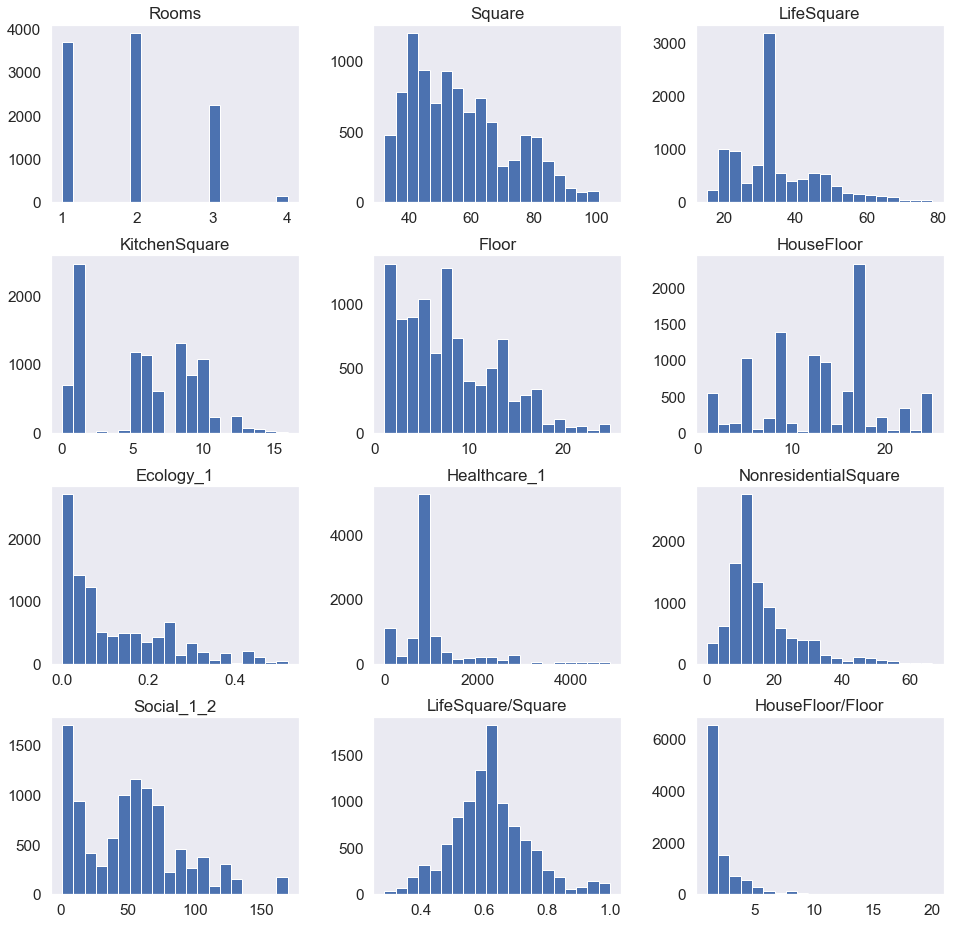

In [89]:
df_num_features.hist(figsize=(16, 16), bins=20, grid=False)
plt.show()

In [90]:
df['LifeSquare/Square'].describe()

count    10000.000000
mean         0.619002
std          0.122064
min          0.284195
25%          0.544510
50%          0.613226
75%          0.683176
max          0.999712
Name: LifeSquare/Square, dtype: float64

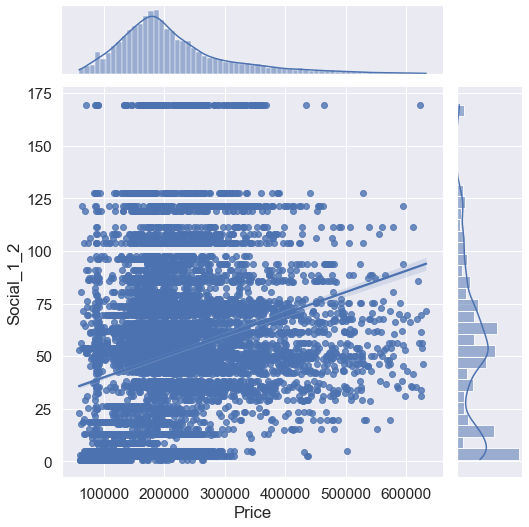

In [91]:
count_rooms = sns.jointplot(df['Price'], df['Social_1_2'], kind='reg')
count_rooms.fig.set_figwidth(8)
count_rooms.fig.set_figheight(8)

plt.show()

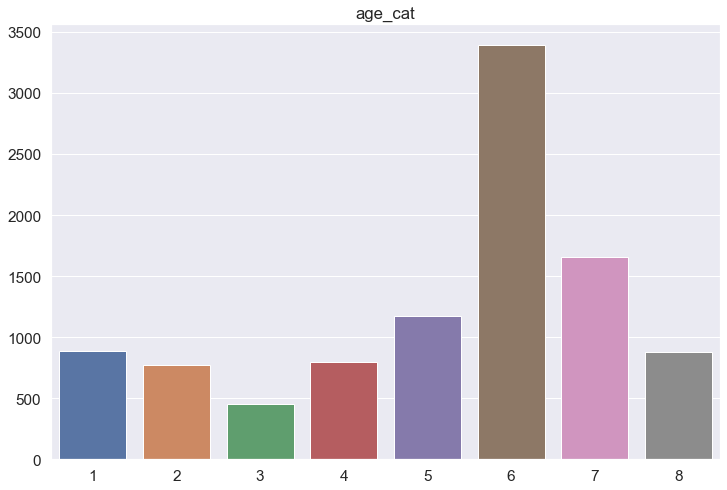

In [92]:
counts = df['age_cat'].value_counts()

plt.figure(figsize=(12, 8))
plt.title('age_cat')
sns.barplot(counts.index, counts.values)

plt.show()

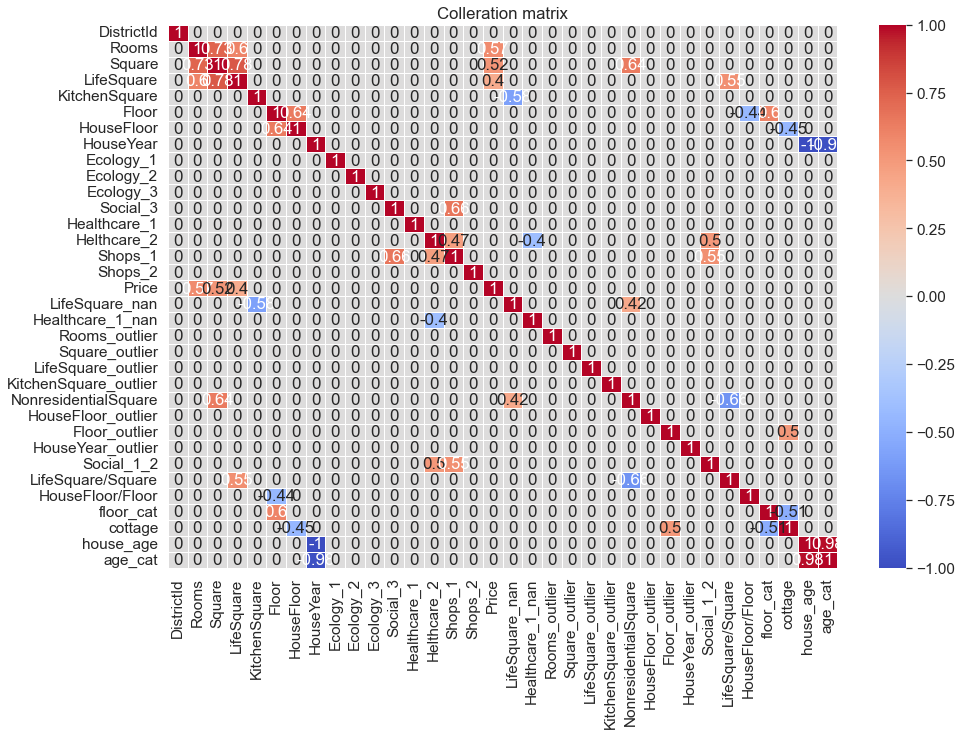

In [93]:
plt.figure(figsize=(15, 10))

sns.set(font_scale=1.4)

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.4] = 0

sns.heatmap(corr_matrix, annot=True, linewidth=.5, cmap='coolwarm')

plt.title('Colleration matrix')
plt.show()

In [94]:
df.drop('HouseYear', axis=1, inplace=True)

In [95]:
from sklearn.model_selection import train_test_split

In [96]:
y = pd.DataFrame(df['Price'], columns=['Price'])
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   10000 non-null  float32
dtypes: float32(1)
memory usage: 39.2 KB


In [97]:
x = df.drop('Price', axis=1)

In [98]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.25, random_state=42)

In [99]:
x_train.to_pickle('x_train.pkl')
y_train.to_pickle('y_train.pkl')

x_valid.to_pickle('x_valid.pkl')
y_valid.to_pickle('y_valid.pkl')